<a href="https://colab.research.google.com/github/harikuttan7136/ELL888-Minor-Graph-learning/blob/main/Graph_learning_large_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sys
import time
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spambase.data to spambase (1).data


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['spambase.data']),header=None)
#df = pd.read_csv(io.BytesIO(uploaded['HTRU_2.csv']),header=None)
df=df.drop_duplicates()

In [ ]:
# seprating data to X and Y labels
X=df.drop(57,axis=1).to_numpy()
Y=df[57].to_numpy()

In [ ]:
# mean normalisation
def meannormalize(X):
  mean=np.mean(X,axis=0)
  std=np.std(X,axis=0)
  return [(X-mean)/std,mean,std]

In [ ]:
X,mean,std=meannormalize(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(3368, 57)

In [ ]:
# running minibatch Kmeans using the MiniBatchKmeans package in sklearn
start = time.time()
n_clusters=3
kmeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=0,batch_size=6,max_iter=10).fit(X_train)
end = time.time()

time_taken=(end-start)

In [ ]:
# kNN getting the edges with kNN graph 
def kNN_graph(X,k=10):
  n=X.shape[0]
  E=np.zeros((n,n))
  D=euclidean_distances(X, X)
  print(D.shape)
  for i in range(n):
    dist=D[i]
    idx = np.argpartition(dist, k)
    count=0
    for j in idx :
      if i!=j and i in (np.argpartition(D[j], k)):
        E[i][j]=1
        count+=1
      if count==k:
        break
  return E,D

In [ ]:
#getting within cluster edges and weights
start=time.time()
mask=[]
within_cluster_edges=[]
within_cluster_distance=[]
tot_in_cluster=[]
centroids=kmeans.cluster_centers_
cluster=kmeans.predict(X_train)
tot_N=X_train.shape[0]
k=10
for i in range(n_clusters):
  temp=(cluster==i)
  mask.append(temp)
  E,D=kNN_graph(X_train[temp],k=k)
  within_cluster_edges.append(E)
  within_cluster_distance.append(D)
  tot_in_cluster.append(E.shape[0])  
end=time.time()
time_taken+=(end-start)

(2478, 2478)
(617, 617)
(273, 273)


In [ ]:
#no of samples in each cluster
print(tot_in_cluster)

[2478, 617, 273]


In [ ]:
# combining the edge and distance matrices to one diagonal matrix 
def diag_block_mat_slicing(edge_list,distance_list,tot_in_cluster):
    N = len(edge_list)
    Edge_matrix=[]
    Distance_matrix=[]
    for i in range(N):
      E=edge_list[i]
      D=distance_list[i]
      temp=np.zeros((len(E),tot_in_cluster[0]))
      temp1=np.zeros((len(E),tot_in_cluster[0]))
      for j in range(1,i):
        temp=np.append(temp,np.zeros((len(E),tot_in_cluster[j])),axis=1)
        temp1=np.append(temp1,np.zeros((len(E),tot_in_cluster[j])),axis=1)
      
      if i!=0:
        temp=np.append(temp,E,axis=1)
        temp1=np.append(temp1,D,axis=1)
      else:
        temp=E
        temp1=D

      for j in range(i+1,N):
        temp=np.append(temp,np.zeros((len(E),tot_in_cluster[j])),axis=1)
        temp1=np.append(temp1,np.zeros((len(E),tot_in_cluster[j])),axis=1)
      Edge_matrix.append(temp)
      Distance_matrix.append(temp1)
    final_list=np.array(Edge_matrix[0])
    final_list1=np.array(Distance_matrix[0])
    for i in range(1,N):
      final_list=np.append(final_list,np.array(Edge_matrix[i]),axis=0)
      final_list1=np.append(final_list1,np.array(Distance_matrix[i]),axis=0)
    return final_list,final_list1

In [ ]:
start=time.time()
Edge_matrix,Distance_matrix=diag_block_mat_slicing(within_cluster_edges,within_cluster_distance,tot_in_cluster)
end=time.time()
time_taken+=(end-start)

In [ ]:
centroids.shape

(3, 57)

In [ ]:
# get the nodes furthest from the centroids
def get_furthest_from_centroid(centroids,mask,Xtrain,k):
  num_clusters=centroids.shape[0]
  furthest_points=[]
  X_furthest=[]
  for i in range(num_clusters):
    temp=Xtrain[mask[i]]
    distance_from_centroid=euclidean_distances(temp,centroids[i].reshape(1,-1)).reshape(-1)
    idx=np.argsort(distance_from_centroid.reshape(-1))[-k:]
    for z in idx:
      X_furthest.append(X_train[z])
    furthest_points.append(idx[:k])
  return np.array(furthest_points),np.array(X_furthest)


In [ ]:
start=time.time()
no_of_points_furthest=30
fur_pnt_idx,X_furthest=get_furthest_from_centroid(centroids,mask,X_train,no_of_points_furthest)
end=time.time()
time_taken+=(end-start)

In [ ]:
fur_pnt_idx.shape

(3, 30)

In [ ]:
(X_furthest).shape

(90, 57)

In [ ]:
start=time.time()
E_within,D_within=kNN_graph(X_furthest,k=10)
end=time.time()
time_taken+=(end-start)

(90, 90)


In [ ]:
#combining within Cluster and Intra cluster Edge and Distance matrices
start=time.time()
for i in range(E_within.shape[0]):
  cluster_i=int(i/no_of_points_furthest)
  x=int(fur_pnt_idx[cluster_i][i%no_of_points_furthest]+np.sum(tot_in_cluster[:cluster_i]))
  for j in range(E_within.shape[0]):
    cluster_j=int(j/no_of_points_furthest)
    if (cluster_i == cluster_j or E_within[i][j]==0):
      continue
    y=int(fur_pnt_idx[cluster_j][j%no_of_points_furthest]+np.sum(tot_in_cluster[:cluster_j]))
    #print("x is "+str(x)+" y is "+str(y))
    Edge_matrix[x][y]=E_within[i][j]
    Distance_matrix[x][y]=D_within[i][j]
end=time.time()
time_taken+=(end-start)

In [ ]:
# pruning the extra edges for each node after combining the Cluster and Intra cluster Edge and Distance matrices
start=time.time()
for i in range(tot_N):
  E_i=Edge_matrix[i]
  D_i=Distance_matrix[i]
  if(np.sum(E_i)>k):
    #print(i)
    no_removed=int(np.sum(E_i)-k)
    idx=np.argsort(D_i*E_i)[-no_removed:]
    for j in idx:
      Edge_matrix[i][j]=0 
end=time.time()
time_taken+=(end-start)    

In [ ]:
#check for seeeing that all nodes have degree=k after pruning
for i in range(tot_N):
  if (np.sum(Edge_matrix[i])!=k):
    print(np.sum(Edge_matrix[i]))

In [ ]:
def gaussian_weight(E,D,var=1):
  return np.multiply(E,np.exp(-D)/(2*var))

In [ ]:
np.max(Edge_matrix)

1.0

In [ ]:
start=time.time()
W=gaussian_weight(Edge_matrix,Distance_matrix,var=1)
end=time.time()
time_taken+=(end-start)

In [ ]:
W.shape

(3368, 3368)

In [ ]:
print("Total time taken for the algorithm is "+str(time_taken)+"s")

Total time taken for the algorithm is 2.3452799320220947s


In [ ]:
#normal KNN to measure the time taken

In [ ]:
start=time.time()
E1,D1=kNN_graph(X_train)
W=gaussian_weight(E1,D1,var=1)
end=time.time()
print(end-start)

(3368, 3368)
2.056877374649048


In [ ]:
 #HTRU_2 
 #1789 samples 1.308 0.706
 #3579 samples 1.97  2.76
 #5369 samples 4.003  6.125
 #7159 samples 6.144  10.211
 #8949 samples 8.698  17.843
 #10738 samples 14.725 28.061
 #12528 samples 15.44 30.71 

Text(0, 0.5, 'Time taken(s)')

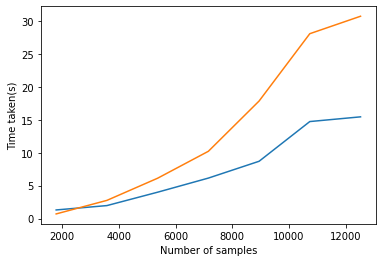

In [ ]:
import matplotlib.pyplot as plt
x1=[1789,3579,5369,7159,8949,10738,12528]
y1=[1.308,1.97,4.003,6.144,8.698,14.725,15.44]
y2=[0.706,2.76,6.125,10.211,17.843,28.061,30.71]
plt.plot(x1, y1, label = "new")
plt.plot(x1, y2, label = "direct")
plt.xlabel('Number of samples')
# Set the y axis label of the current axis.
plt.ylabel('Time taken(s)')

In [ ]:
tot_N

3368

In [ ]:
edge=[]
x0=[]
x1=[]
for i in range(tot_N):
  for j in range(tot_N):
    if i<tot_in_cluster[0] and j>tot_in_cluster[0] and j<tot_in_cluster[0]+tot_in_cluster[1] and Edge_matrix[i][j]>0:
      x0.append(i)
      x1.append(j)
      edge.append([i,j])

In [ ]:
tot_in_cluster

[2478, 617, 273]

In [ ]:
x0=np.unique(x0)
x1=np.unique(x1)

In [ ]:
import networkx as nx 
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
G = nx.DiGraph()

In [ ]:
#G.add_nodes_from(np.unique(x0),bipartite=0)
#G.add_nodes_from(np.unique(x1),bipartite=1)
for i in x0:
  G.add_node(i,pos=X_train[i],color="blue")
for j in x1:
  G.add_node(j,pos=X_train[j],color="green")

In [ ]:
G.add_edges_from(edge)

In [ ]:
nodePos = nx.circular_layout(G)

In [ ]:
colored_dict = nx.get_node_attributes(G, 'color')

default_color = 'blue'
color_seq = [colored_dict.get(node, default_color) for node in G.nodes()]



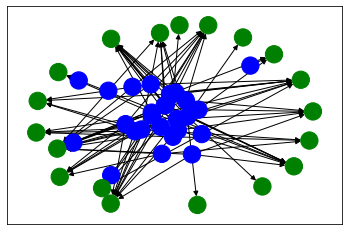

In [ ]:
nx.draw_networkx(G ,with_labels=False,node_color=color_seq)